
# TA-13 — Simulasi Predator–Prey (Lotka–Volterra) dengan Data Riil (Padi–Wereng)

Notebook ini mengikuti instruksi TA-13 pada modul:
1. **Formulasi model Lotka–Volterra & estimasi awal parameter (α, β, γ, δ)**  
2. **Implementasi simulasi ODE** (solver `scipy.integrate.solve_ivp` + opsi RK4)  
3. **Tuning & validasi** (overlay data vs simulasi)  
4. **Analisis phase portrait** (x vs y)

Dataset yang dipakai: **Predator-Prey .csv** (kolom padi & wereng).


In [2]:
# === 0) Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

np.set_printoptions(precision=6, suppress=True)

csv_path = "Predator-Prey .csv"   # path relatif
df = pd.read_csv(csv_path)

print("Kolom:", list(df.columns))
df.head()


Kolom: ['Waktu_hari', 'Padi_tanpa_kg_ha', 'Wereng_tanpa_ind_ha', 'Padi_kontrol_kg_ha', 'Wereng_kontrol_ind_ha']


,Waktu_hari,Padi_tanpa_kg_ha,Wereng_tanpa_ind_ha,Padi_kontrol_kg_ha,Wereng_kontrol_ind_ha
0,0.0,800.000000,100.000000,800.000000,100.000000
1,0.1,625.521703,172.167925,625.521703,172.167925
2,0.2,424.066169,254.217533,424.066169,254.217533
3,0.3,250.446909,321.985549,250.446909,321.985549
4,0.4,134.257775,362.949050,134.257775,362.949050



## 1) Load data Kaggle & visualisasi data mentah

Kita gunakan skenario **tanpa kontrol** untuk pemodelan Lotka–Volterra standar:
- Prey *(mangsa)*: `Padi_tanpa_kg_ha`
- Predator *(pemangsa/penekan)*: `Wereng_tanpa_ind_ha`
- Waktu: `Waktu_hari`


Rentang waktu: (0.0, 200.0) hari
x0, y0: 800.0 100.0
Jumlah titik: 2001


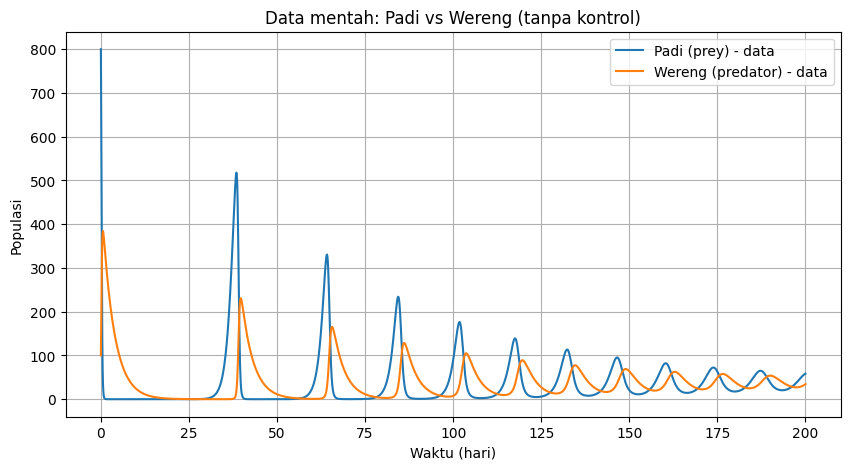

In [3]:

t = df["Waktu_hari"].to_numpy()
x_raw = df["Padi_tanpa_kg_ha"].to_numpy()          # prey
y_raw = df["Wereng_tanpa_ind_ha"].to_numpy()       # predator

print("Rentang waktu:", (t.min(), t.max()), "hari")
print("x0, y0:", x_raw[0], y_raw[0])
print("Jumlah titik:", len(t))

# Plot data mentah (time series)
plt.figure(figsize=(10,5))
plt.plot(t, x_raw, label="Padi (prey) - data")
plt.plot(t, y_raw, label="Wereng (predator) - data")
plt.xlabel("Waktu (hari)")
plt.ylabel("Populasi")
plt.title("Data mentah: Padi vs Wereng (tanpa kontrol)")
plt.grid(True)
plt.legend()
plt.show()



## 2) Formulasi Model Lotka–Volterra

Sistem ODE standar:

\[
\frac{dx}{dt} = \alpha x - \beta x y
\qquad
\frac{dy}{dt} = \delta x y - \gamma y
\]

Makna parameter:
- **α**: laju pertumbuhan prey (padi) saat predator sangat kecil
- **β**: laju predasi / tekanan predator pada prey
- **δ**: efisiensi konversi prey → pertumbuhan predator
- **γ**: laju kematian/penurunan predator saat prey rendah


In [4]:

def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]



## 3) (Disarankan) Penskalaan Data

Populasi padi (kg/ha) jauh lebih besar dibanding wereng (ind/ha). Untuk kestabilan numerik, kita skala:

- \(x = x_{raw} / s_x\)
- \(y = y_{raw} / s_y\)

**Catatan:** parameter hasil fitting berlaku pada sistem yang sudah diskalakan. Untuk plot, kita kembalikan ke satuan asli.


Scaled x0,y0: 0.8 1.0


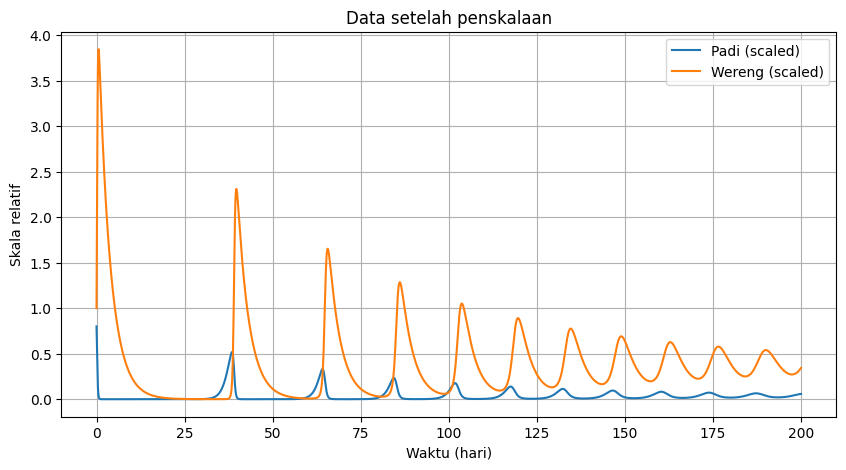

In [5]:

sx = 1000.0  # skala prey (padi)
sy = 100.0   # skala predator (wereng)

x = x_raw / sx
y = y_raw / sy

x0, y0 = x[0], y[0]
print("Scaled x0,y0:", x0, y0)

# cek sekilas skala
plt.figure(figsize=(10,5))
plt.plot(t, x, label="Padi (scaled)")
plt.plot(t, y, label="Wereng (scaled)")
plt.xlabel("Waktu (hari)")
plt.ylabel("Skala relatif")
plt.title("Data setelah penskalaan")
plt.grid(True)
plt.legend()
plt.show()



## 4) Estimasi Awal Parameter (Heuristik dari Data)

Estimasi awal hanya perkiraan kasar, sesuai instruksi TA:
- **α** kira-kira dari laju kenaikan prey saat predator relatif kecil
- **β, δ, γ** diperkirakan dengan pendekatan turunan numerik (finite difference)

Metode berikut **tidak harus sempurna** — fungsinya memberi titik awal untuk proses tuning/optimisasi.


In [6]:

# Turunan numerik
dt = np.diff(t)
dx = np.diff(x)
dy = np.diff(y)

# gunakan midpoints untuk memasangkan nilai x,y dengan turunan
t_mid = (t[:-1] + t[1:]) / 2
x_mid = (x[:-1] + x[1:]) / 2
y_mid = (y[:-1] + y[1:]) / 2

dxdt = dx / dt
dydt = dy / dt

# Heuristik memilih kondisi "predator relatif kecil"
# (ambil 20% terendah predator)
q = np.quantile(y_mid, 0.2)
mask_low_pred = y_mid <= q

# α ~ median(d/dt ln x) pada kondisi predator rendah dan x>0 serta dxdt>0
mask_alpha = mask_low_pred & (x_mid > 0) & (dxdt > 0)
if mask_alpha.sum() > 10:
    alpha0 = np.median(dxdt[mask_alpha] / x_mid[mask_alpha])
else:
    # fallback: pakai nilai kecil yang masuk akal
    alpha0 = 1.0

# β ~ (αx - dx/dt)/(x*y) pada kondisi x,y>0
mask_beta = (x_mid > 0) & (y_mid > 0)
beta_candidates = (alpha0 * x_mid[mask_beta] - dxdt[mask_beta]) / (x_mid[mask_beta] * y_mid[mask_beta])
beta_candidates = beta_candidates[np.isfinite(beta_candidates)]
beta_candidates = beta_candidates[beta_candidates > 0]
beta0 = np.median(beta_candidates) if len(beta_candidates) else 0.5

# γ ~ - (1/y) dy/dt saat prey rendah (ambil 20% terendah x)
qx = np.quantile(x_mid, 0.2)
mask_low_prey = x_mid <= qx
mask_gamma = mask_low_prey & (y_mid > 0) & (dydt < 0)
if mask_gamma.sum() > 10:
    gamma0 = np.median(-dydt[mask_gamma] / y_mid[mask_gamma])
else:
    gamma0 = 1.0

# δ ~ (dy/dt + γy)/(x*y) pada kondisi x,y>0
delta_candidates = (dydt[mask_beta] + gamma0 * y_mid[mask_beta]) / (x_mid[mask_beta] * y_mid[mask_beta])
delta_candidates = delta_candidates[np.isfinite(delta_candidates)]
delta_candidates = delta_candidates[delta_candidates > 0]
delta0 = np.median(delta_candidates) if len(delta_candidates) else 0.5

init_params = np.array([alpha0, beta0, delta0, gamma0])
print("Estimasi awal [alpha, beta, delta, gamma] =", init_params)


Estimasi awal [alpha, beta, delta, gamma] = [0.761747 1.947206 7.994249 0.299951]



## 5) Implementasi Simulasi ODE

Instruksi TA meminta solver ODE (mis. `odeint`/Runge–Kutta). Di sini:
- utama: `solve_ivp` (RK45 bawaan SciPy)
- opsional: RK4 manual (disediakan sebagai alternatif)


In [7]:

def simulate_lv(params, t_eval=t, x0=x0, y0=y0):
    alpha, beta, delta, gamma = params
    sol = solve_ivp(
        fun=lambda tt, zz: lotka_volterra(tt, zz, alpha, beta, delta, gamma),
        t_span=(t_eval.min(), t_eval.max()),
        y0=[x0, y0],
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-9
    )
    if not sol.success:
        return None
    xs, ys = sol.y[0], sol.y[1]
    return xs, ys

# RK4 manual (opsional)
def rk4_simulate(params, t_eval=t, x0=x0, y0=y0):
    alpha, beta, delta, gamma = params
    xs = np.zeros_like(t_eval, dtype=float)
    ys = np.zeros_like(t_eval, dtype=float)
    xs[0], ys[0] = x0, y0

    for i in range(len(t_eval) - 1):
        h = t_eval[i+1] - t_eval[i]
        z = np.array([xs[i], ys[i]], dtype=float)

        def f(tt, zz):
            return np.array(lotka_volterra(tt, zz, alpha, beta, delta, gamma), dtype=float)

        k1 = f(t_eval[i], z)
        k2 = f(t_eval[i] + h/2, z + h*k1/2)
        k3 = f(t_eval[i] + h/2, z + h*k2/2)
        k4 = f(t_eval[i] + h,   z + h*k3)

        z_next = z + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        xs[i+1], ys[i+1] = z_next[0], z_next[1]

        # jaga agar tidak negatif (opsional)
        if xs[i+1] < 0: xs[i+1] = 0
        if ys[i+1] < 0: ys[i+1] = 0

    return xs, ys

# uji simulasi pakai estimasi awal
test = simulate_lv(init_params)
print("Simulasi awal sukses?" , test is not None)


Simulasi awal sukses? True



## 6) Tuning & Validasi (Fitting Parameter)

Kita minimalkan error gabungan prey + predator (MSE) antara data (scaled) dan hasil simulasi.

Catatan:
- Kita pakai optimisasi numerik (`minimize`) sebagai tuning otomatis.
- Parameter dibatasi > 0 agar masuk akal secara biologis.


In [8]:

def loss_mse(params):
    params = np.array(params, dtype=float)
    if np.any(params <= 0) or np.any(~np.isfinite(params)):
        return 1e18

    sim = simulate_lv(params)
    if sim is None:
        return 1e18
    xs, ys = sim

    # MSE gabungan
    err_x = np.mean((xs - x)**2)
    err_y = np.mean((ys - y)**2)
    return err_x + err_y

# Optimisasi (Nelder-Mead biasanya cukup stabil untuk problem seperti ini)
res = minimize(loss_mse, init_params, method="Nelder-Mead",
               options={"maxiter": 5000, "xatol": 1e-8, "fatol": 1e-8})

best_params = res.x
print("Sukses:", res.success, "| iter:", res.nit)
print("Best params [alpha, beta, delta, gamma] =", best_params)
print("Best loss =", res.fun)

x_sim, y_sim = simulate_lv(best_params)

# Kembalikan ke skala asli untuk overlay
x_sim_raw = x_sim * sx
y_sim_raw = y_sim * sy


Sukses: True | iter: 581
Best params [alpha, beta, delta, gamma] = [0.894646 4.358147 4.7853   0.251426]
Best loss = 0.27558168181533804



## 7) Plot Perbandingan (Overlay Time Series)

Sesuai instruksi TA:
- **Garis putus-putus**: data asli (Kaggle)
- **Garis solid**: hasil simulasi (Lotka–Volterra)


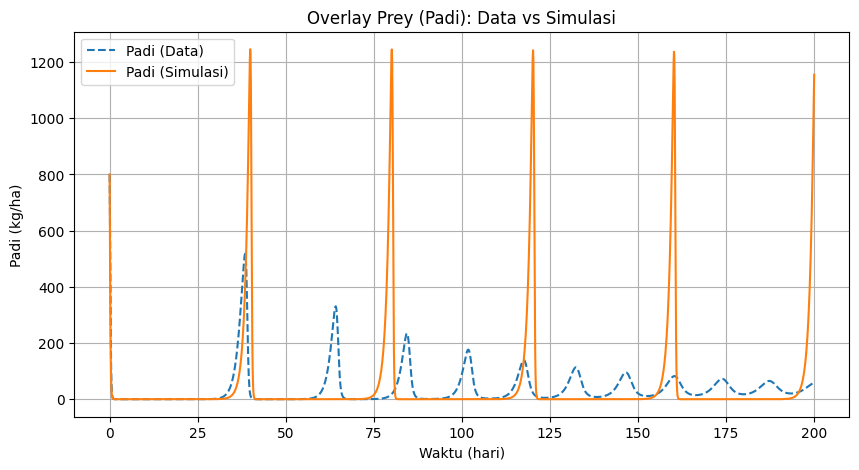

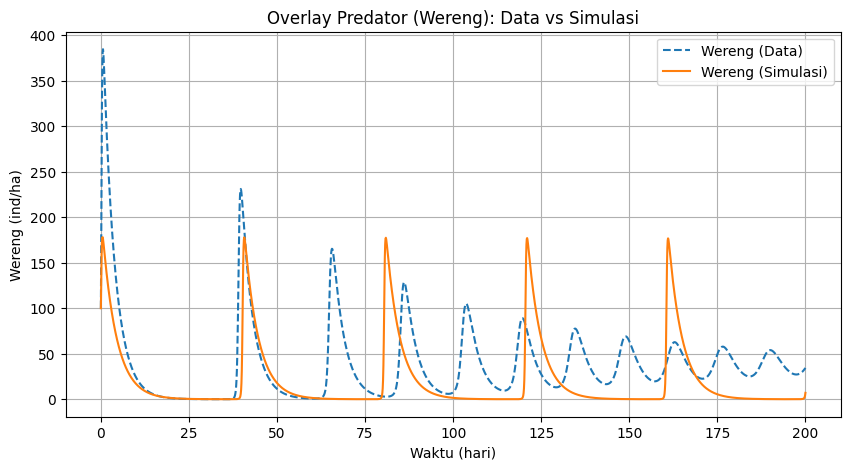

In [10]:

plt.figure(figsize=(10,5))
plt.plot(t, x_raw, linestyle="--", label="Padi (Data)")
plt.plot(t, x_sim_raw, linestyle="-", label="Padi (Simulasi)")
plt.xlabel("Waktu (hari)")
plt.ylabel("Padi (kg/ha)")
plt.title("Overlay Prey (Padi): Data vs Simulasi")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(t, y_raw, linestyle="--", label="Wereng (Data)")
plt.plot(t, y_sim_raw, linestyle="-", label="Wereng (Simulasi)")
plt.xlabel("Waktu (hari)")
plt.ylabel("Wereng (ind/ha)")
plt.title("Overlay Predator (Wereng): Data vs Simulasi")
plt.grid(True)
plt.legend()
plt.show()



## 8) Analisis Phase Portrait (x vs y)

Hilangkan variabel waktu dan plot hubungan prey–predator:
- Apakah lintasan membentuk **orbit tertutup** (siklus) atau **spiral** menuju titik keseimbangan?

Kita plot data dan simulasi agar mudah dibandingkan.


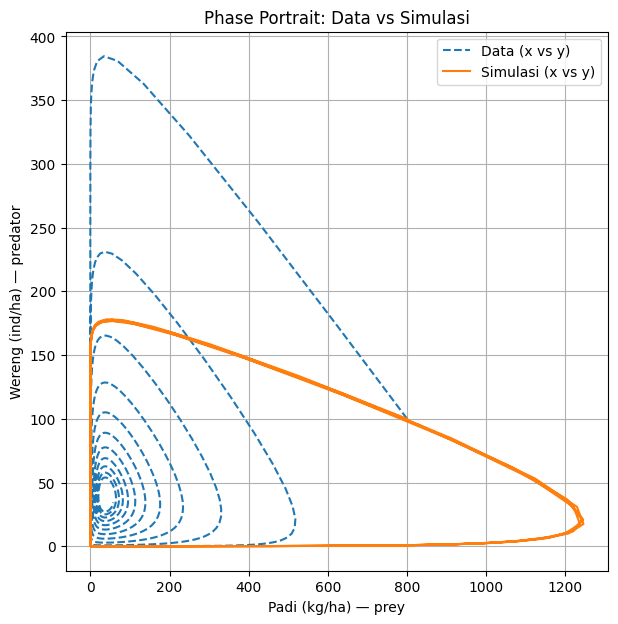

In [11]:

plt.figure(figsize=(7,7))
plt.plot(x_raw, y_raw, linestyle="--", label="Data (x vs y)")
plt.plot(x_sim_raw, y_sim_raw, linestyle="-", label="Simulasi (x vs y)")
plt.xlabel("Padi (kg/ha) — prey")
plt.ylabel("Wereng (ind/ha) — predator")
plt.title("Phase Portrait: Data vs Simulasi")
plt.grid(True)
plt.legend()
plt.show()



## 9) Ringkasan Interpretasi (isi untuk laporan)

- **Prey (padi)** cenderung naik saat tekanan predator rendah, lalu turun saat predator meningkat (istilah \(\beta x y\)).
- **Predator (wereng)** meningkat ketika prey cukup tinggi (istilah \(\delta x y\)), lalu menurun saat prey rendah (istilah \(\gamma y\)).
- Jika phase portrait mendekati **orbit tertutup**, sistem menunjukkan **osilasi berulang**; jika membentuk **spiral ke tengah**, sistem menuju **keseimbangan** (equilibrium).

Parameter terbaik (pada data yang diskalakan) tercetak pada bagian tuning.
